In [50]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Part 1

### Read images

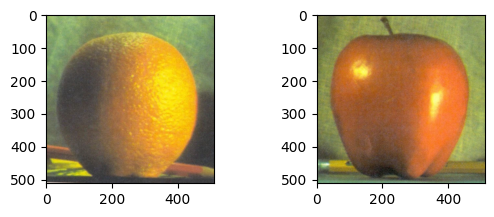

In [51]:
fig = plt.figure()

orange = cv2.imread("../../images/orange.webp")
o = fig.add_subplot(2,2,1)
o.imshow(cv2.cvtColor(orange, cv2.COLOR_BGR2RGB))

apple = cv2.imread("../../images/apple.jpg")
a = fig.add_subplot(2,2,2)
a.imshow(cv2.cvtColor(apple, cv2.COLOR_BGR2RGB))

### Gaussian Pyramid

In [52]:
nPy = 6
real = np.hstack((apple[:,:apple.shape[1]//2],orange[:,orange.shape[1]//2:]))

# Apple
applecopy = apple.copy()
aGauss = [applecopy]
for i in range(nPy):
    applecopy = cv2.pyrDown(applecopy)
    aGauss.append(applecopy)
# Orange
orangecopy = orange.copy()
oGauss = [orangecopy]
for i in range(nPy):
    orangecopy = cv2.pyrDown(orangecopy)
    oGauss.append(orangecopy)


### Laplacian Pyramid

In [53]:
# Apple
applecopy = aGauss[nPy-1]
aLapl = [applecopy]
for i in range(nPy-1, 0, -1):
    size = (aGauss[i - 1].shape[1], aGauss[i - 1].shape[0])
    appleUP = cv2.pyrUp(aGauss[i], dstsize=size)
    laplacian = cv2.subtract(aGauss[i-1], appleUP)
    aLapl.append(laplacian)

# Orange
orangecopy = oGauss[nPy-1]
oLapl = [orangecopy]
for i in range(nPy-1, 0, -1):
    size = (oGauss[i - 1].shape[1], oGauss[i - 1].shape[0])
    orangeUP = cv2.pyrUp(oGauss[i], dstsize=size)
    laplacian = cv2.subtract(oGauss[i-1], orangeUP)
    oLapl.append(laplacian)

### Join both halves for each Laplacian pyramid layer

In [54]:
apple_orange_py = []
for apple_lap, orange_lap in zip(aLapl, oLapl):
    cols, rows, ch = apple_lap.shape
    laplacian = np.hstack((apple_lap[:, :rows//2], orange_lap[:, rows//2:]))
    apple_orange_py.append(laplacian)

### Reconstruct image

In [55]:
apple_orange_reconstruct = apple_orange_py[0]
for i in range(1, nPy):
    size = (apple_orange_py[i].shape[1], apple_orange_py[i].shape[0])
    apple_orange_reconstruct = cv2.pyrUp(apple_orange_reconstruct, dstsize=size)
    # plt.imshow(cv2.cvtColor(apple_orange_py[i], cv2.COLOR_BGR2RGB))
    # plt.show()
    # plt.imshow(cv2.cvtColor(apple_orange_reconstruct, cv2.COLOR_BGR2RGB))
    # plt.show()
    apple_orange_reconstruct = cv2.add(apple_orange_py[i], apple_orange_reconstruct)

### Show results

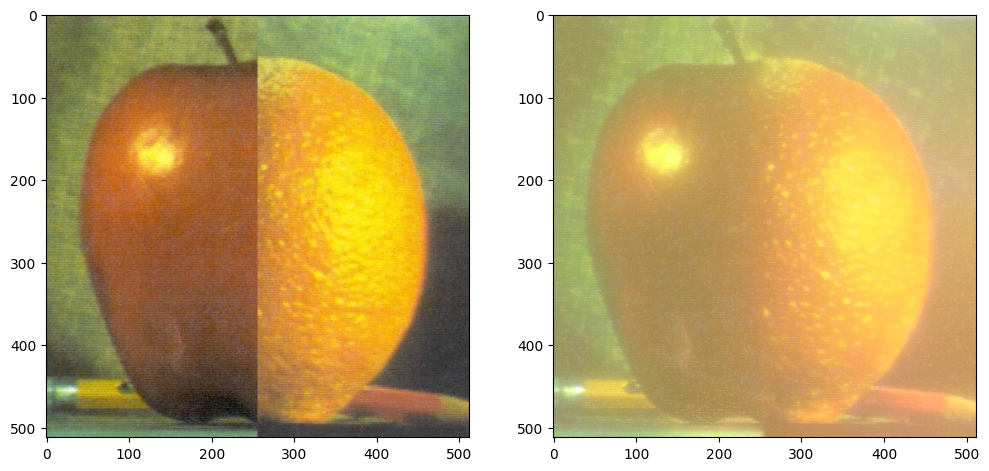

True

In [56]:
plt.figure(figsize=(12,12))
plt.subplot(121), plt.imshow(cv2.cvtColor(real, cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(apple_orange_reconstruct, cv2.COLOR_BGR2RGB))
plt.show()

cv2.imwrite('DirectBlending.jpg',real)
cv2.imwrite('PyramidBlending.jpg',apple_orange_reconstruct)

# Part 2

### Read images

(484, 269, 3)

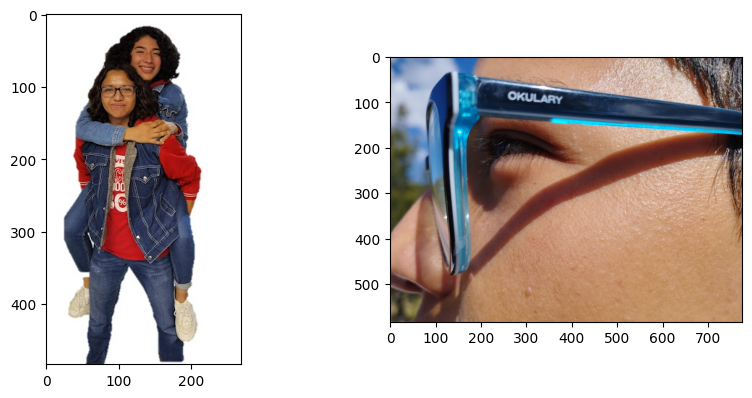

In [57]:
fig = plt.figure(figsize=(10,10))

tattoo = cv2.imread("../../images/Us.jpg")
o = fig.add_subplot(2,2,1)
tattoo = tattoo[100:, :]
o.imshow(cv2.cvtColor(tattoo, cv2.COLOR_BGR2RGB))

skin = cv2.imread("../../images/Me.jpg")
a = fig.add_subplot(2,2,2)
a.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
tattoo.shape

### Preview
The idea is to tattoo that pic on Lalito's face

(484, 269, 3)


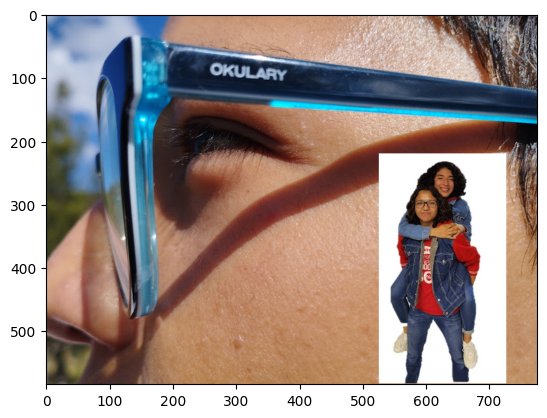

In [58]:
print(tattoo.shape)
s = 0.75
dim = np.array([tattoo.shape[1]*s, tattoo.shape[0]*s])
dim = dim.astype(int)

skinT = np.copy(skin)
p = cv2.resize(tattoo, dim)
x, y = 525, 220
skinT[y :p.shape[0] + y, x :p.shape[1] + x] = p
plt.imshow(cv2.cvtColor(skinT, cv2.COLOR_BGR2RGB))

### Design tattoo
* Setting the second image up in order to fit on the first one
* Creating the gray-scale mask.

In [59]:
threshold = 180
mask = cv2.cvtColor(tattoo, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(mask, threshold, threshold, cv2.THRESH_BINARY)
mask = mask/threshold
mask[300:] = mask[300:]+0.3
mask[350:] = mask[350:]+0.3
mask[400:] = mask[400:]+0.3
for i in range(mask.shape[0]):        
    for j in range(mask.shape[1]):        
        mask[i, j] = np.min((mask[i, j], 1))
mask[300:] = cv2.filter2D(mask[300:], ddepth = -1, kernel = np.array([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])/25)
mask = cv2.filter2D(mask, ddepth = -1, kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/16)

In [60]:
print(tattoo.shape)
s = 0.75
dim = np.array([tattoo.shape[1]*s, tattoo.shape[0]*s])
dim = dim.astype(int)

tattoo = cv2.resize(tattoo, dim)
back = np.zeros_like(skin)
back[y :tattoo.shape[0] + y, x :tattoo.shape[1] + x] = tattoo
tattoo = np.copy(back)

(484, 269, 3)


(484, 269)


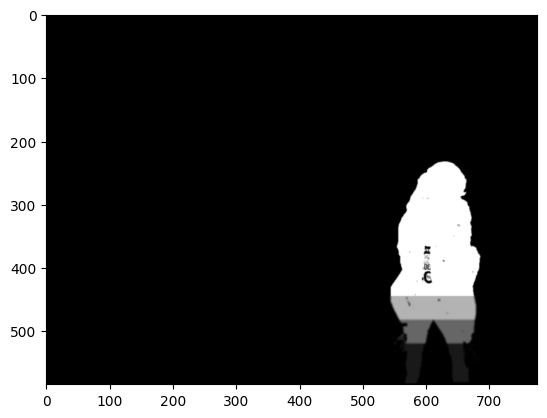

In [61]:
print(mask.shape)
mask = cv2.resize(mask, dim)
back = np.zeros((skin.shape[0], skin.shape[1]))
back[y :mask.shape[0] + y, x :mask.shape[1] + x] = 1 - mask
mask = np.copy(back)
plt.imshow(mask, cmap = "gray")

### Blending image

In [62]:
nLevels = 3

### Gaussian pyramids

In [63]:
s = np.copy(skin)
gpSkin = [s]
for i in range(nLevels):
    s = cv2.pyrDown(s)
    gpSkin.append(s)

In [64]:
t = np.copy(tattoo)
gpTattoo = [t]
for i in range(nLevels):
    t = cv2.pyrDown(t)
    gpTattoo.append(t)

In [65]:
m = np.copy(mask)
gpMask = [m]
for i in range(nLevels - 1):
    m = cv2.pyrDown(m)
    gpMask.append(m)

### Laplacian pyramids

In [66]:
lpSkin = [gpSkin[nLevels - 1]]
for i in range(nLevels - 1, 0, -1):
    bS = cv2.pyrUp(gpSkin[i], dstsize = (gpSkin[i-1].shape[1], gpSkin[i-1].shape[0]))
    l = cv2.subtract(gpSkin[i-1], bS)
    lpSkin.append(l)

In [67]:
lpTattoo = [gpTattoo[nLevels - 1]]
for i in range(nLevels - 1, 0, -1):
    bT = cv2.pyrUp(gpTattoo[i], dstsize = (gpTattoo[i-1].shape[1], gpTattoo[i-1].shape[0]))
    l = cv2.subtract(gpTattoo[i-1], bT)
    lpTattoo.append(l)

### Merging

In [68]:
lFinal = []
for gM, l in zip(gpMask[::-1], zip(lpSkin, lpTattoo)):
    lS, lT = l
    gM = np.stack([gM, gM, gM], -1)
    lF = np.add(np.multiply(lS, (1 - gM)), np.multiply(lT, gM))
    lFinal.append(lF)

### Reconstruction

In [69]:
r = lFinal[0]
for i in range(1, nLevels):
    r = cv2.pyrUp(r, dstsize=(lpSkin[i].shape[1], lpSkin[i].shape[0]))
    r = np.add(lFinal[i], r) 

### Final Result

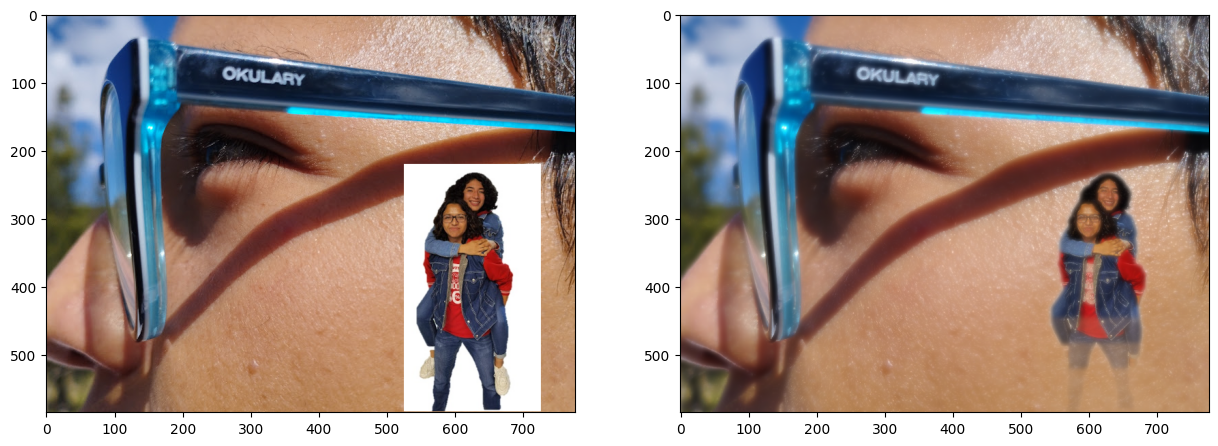

In [70]:
r = r / np.max(r)
r = r.astype('float32')

plt.imsave('SL.jpg',cv2.cvtColor(r, cv2.COLOR_BGR2RGB))
# plt.imshow(cv2.cvtColor(r, cv2.COLOR_BGR2RGB))

plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(skinT, cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(r, cv2.COLOR_BGR2RGB))
plt.show()
